In [1]:
import os
import torch
import wandb
import rasterio
import logging

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import pandas as pd

from glob import glob
from codecarbon import EmissionsTracker
from tqdm.notebook import tqdm
from argparse import ArgumentParser
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from represent.models.uc4_resnet import UC4ResNet
from represent.callbacks.delayed_unfreeze import DelayedUnfreeze
from represent.models.moco import DualMoco
from represent.transforms.augmentations import get_data_augmentation
from represent.tools.utils import seed_all
from represent.tools.plots import plot_img_grid

from pl_bolts.models.regression import LogisticRegression
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime

from tqdm.notebook import tqdm

torch.backends.cudnn.benchmark = True
logger = logging.getLogger()
logger.setLevel(logging.WARNING)


/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
config = dict(
    # DataModule Settings
    data_dir = "/data/lloyd/RepreSent/UC4/WHUS2-CD+/prepared/output/",
    seed = 42,
    batch_size = 4,
    num_workers = 16,
    training_set_fraction = 0.70,
    limit_dataset = 0.5,
    patch_size = 256,
    
    # Trainer Settings
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    
    # Model Parameters
    use_mlp = False,
    num_classes = 1,
    input_ch = 13,
    backbone = "resnet18",
    segmentation = True,
    checkpoint = "represent/represent/weights/moco_resnet18.pth",
    
    # Optimizer Parameteres
    optimizer = "Adam",
    scheduler = "CosineAnnealingLR",
    momentum = 0.9,
    max_epochs = 50,
    learning_rate = 2e-2,
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC4ResNet.add_model_specific_args(parser)
parser = UC4CloudDetectionDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])

Global seed set to 42


In [3]:
wandb.finish()
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC4_ResNet_{ts}"
logger = WandbLogger(project="RepreSent_UC4", name=run_name, log_model=True, save_code=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [4]:
uc4_datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

In [5]:
# args.classification_head = torch.nn.Linear(512, config['num_classes'])
args.classification_head = torch.nn.Sequential(
    torch.nn.Conv2d(512, 64, kernel_size=3, padding=1),
    torch.nn.InstanceNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, config['num_classes'], kernel_size=1)
)

model = UC4ResNet(**args.__dict__)

# Load MoCo weights
Load the MoCo weights and remap the names to match a standard ResNet implementation

In [6]:
if 'checkpoint' in config:
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s2_moco.encoder_q")

# Finetune the model

In [7]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC2_MoCo/{run_name}',
    filename="{epoch}-{val_acc:.2f}",
    monitor="val_acc",
    mode="max",
    save_last=True,
)

early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

unfreezer = DelayedUnfreeze(backbone_id="model", unfreeze_at_epoch=5, train_frozen_bn=True, reset_lr=7e-3)

callbacks = [checkpointer, early_stopping_callback, unfreezer]

# for p in model.model.parameters():
#     p.requires_grad = False

In [8]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
try:
    run = trainer.fit(model, datamodule=uc4_datamodule)
finally:
    wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | model            | ResNet             | 11.2 M
1 | classifier       | Sequential         | 295 K 
2 | iou_metric_train | BinaryJaccardIndex | 0     
3 | iou_metric_val   | BinaryJaccardIndex | 0     
4 | oa_train         | BinaryAccuracy     | 0     
5 | oa_val           | BinaryAccuracy     | 0     
--------------------------------------------------------
304 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
46.012    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/callbacks/finetuning.py:210: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


# Find Learning Rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.052480746024977286
Restoring states from the checkpoint path at /home/lloyd/Documents/Experiments/RepreSent/.lr_find_dac607f3-29df-4cd5-8893-59bcc14cdf7b.ckpt


0.052480746024977286

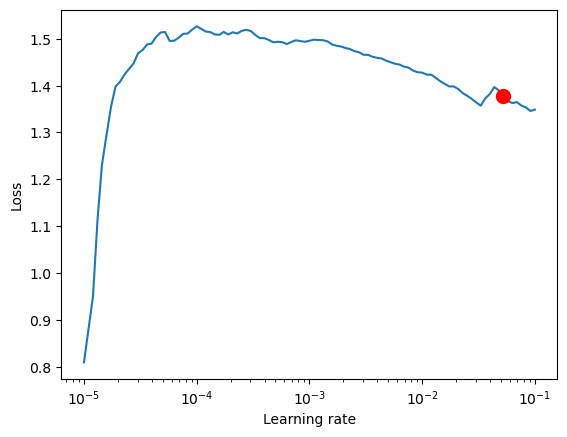

In [9]:
trainer_lr = pl.Trainer.from_argparse_args(args, enable_checkpointing=False, logger=None, auto_lr_find=True)

lr_finder = trainer_lr.tune(model, datamodule=uc4_datamodule, lr_find_kwargs={"min_lr": 1e-7, "max_lr": 1e-1,})

fig=lr_finder['lr_find'].plot(suggest=True)
fig.show()
lr_finder['lr_find'].suggestion()

# Evaluate the Model

In [10]:
from glob import glob

import wandb
run = wandb.init()
artifact = run.use_artifact('hughes-lloyd/RepreSent_UC4/model-1fslztlw:v0', type='model')
artifact_dir = artifact.download()

checkpoint = os.path.join(artifact_dir, "model.ckpt")
# idx = -5
# checkpoints = glob(f"checkpoints/UC5ResNet/*/*.ckpt")
# checkpoint = checkpoints[idx]
# print("Using checkpoint ", checkpoint)
# checkpoint = "represent/represent/weights/uc5_moco_resnet18_4px.pth"

model = UC4ResNet(**args.__dict__)
model.load_state_dict(torch.load(checkpoint)['state_dict'], strict=True)

# model.load_from_checkpoint(checkpoint)
# model.classifier.load_state_dict(torch.load(checkpoint)['state_dict'], strict=False)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.0.", stream_id=0)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.1.", stream_id=1, input_ch_subset=s2_bands)

model = model.to('cuda')
model = model.eval()

wandb: Downloading large artifact model-1fslztlw:v0, 131.78MB. 1 files... Done. 0:0:0.1


In [14]:
artifact_dir

'./artifacts/model-kw6cfueq:v0'

In [11]:
from tqdm.notebook import tqdm
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex

args.batch_size = 8
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

datamodule.setup(stage="test")

preds = []
targets = []

metrics = MetricCollection([
    BinaryAccuracy(),
    BinaryPrecision(),
    BinaryRecall(),
    BinaryF1Score(),
    BinaryJaccardIndex(),
]).to("cuda")

c = 0
with torch.no_grad():
    for batch in tqdm(datamodule.test_dataloader()):
        x, y_true = batch
        x, y_true = x.to('cuda'), y_true.to('cuda')
        y_pred = model(x)
        p_pred = torch.sigmoid(y_pred)
        metrics(p_pred, y_true)

  0%|          | 0/1142 [00:00<?, ?it/s]

In [12]:
metrics.compute()

{'BinaryAccuracy': tensor(0.9761, device='cuda:0'),
 'BinaryPrecision': tensor(0.9252, device='cuda:0'),
 'BinaryRecall': tensor(0.7821, device='cuda:0'),
 'BinaryF1Score': tensor(0.8477, device='cuda:0'),
 'BinaryJaccardIndex': tensor(0.7356, device='cuda:0')}

In [103]:
p = torch.sigmoid(y_pred)
p.shape, y_true.shape, x.shape

(torch.Size([2, 1, 384, 384]),
 torch.Size([2, 1, 384, 384]),
 torch.Size([2, 13, 384, 384]))

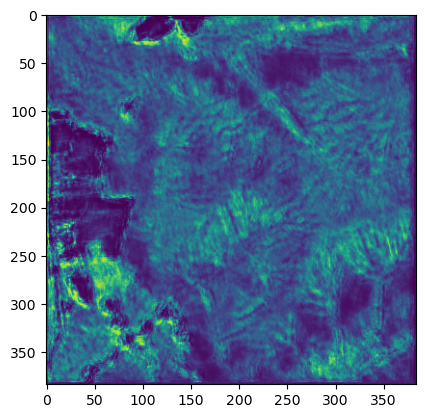

In [105]:
plt.figure()
plt.imshow(p.cpu().numpy()[0,0,])

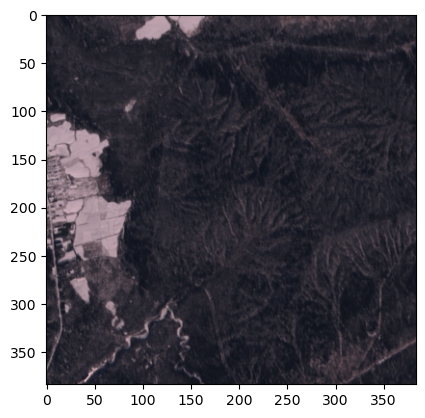

In [94]:
plt.figure()
plt.imshow(x.cpu().numpy()[0,].transpose(1,2,0)[:,:,(3,2,1)])
# plt.imshow(y_true.cpu().numpy()[0,].transpose(1,2,0), alpha=0.3)
# plt.imshow(p_pred.cpu().numpy()[0,].transpose(1,2,0) >= 0.9, alpha=0.3)

In [7]:
uc4_datamodule.setup("test")
dset = uc4_datamodule.test_dataset

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


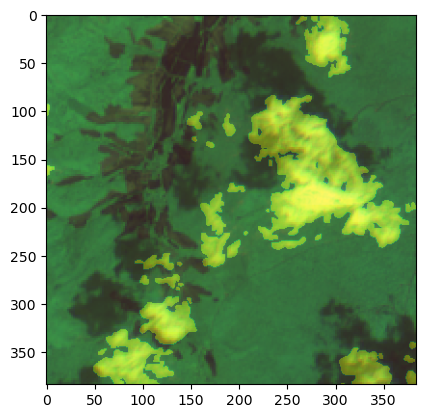

In [8]:
img, lbl = dset[2335]

plt.figure()
plt.imshow(img.numpy().transpose(1,2,0)[:,:,(2,5,9)]*2)
plt.imshow(lbl.numpy().transpose(1,2,0), alpha=0.3)


In [9]:
with torch.no_grad():
    o = model(torch.from_numpy(img.numpy()[np.newaxis,]))

In [18]:
L = torch.from_numpy(lbl.numpy()[np.newaxis,]).long()

In [11]:
from represent.losses.functional import soft_dice_loss_with_logits

In [22]:
soft_dice_loss_with_logits(o, L.float())

tensor(0.7364)

In [23]:
import torch.nn.functional as F

F.binary_cross_entropy_with_logits(o, L.float())

tensor(0.4946)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


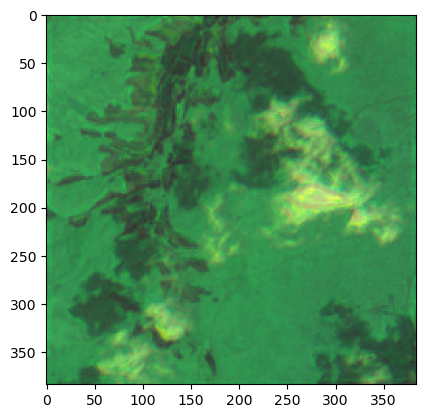

In [25]:
plt.figure()
plt.imshow(img.numpy().transpose(1,2,0)[:,:,(2,5,9)]*2)
plt.imshow(torch.sigmoid(o)[0,].numpy().transpose(1,2,0), alpha=0.3)